Using device: cpu

 STARTING EXPERIMENT FOR: FashionMNIST 

--- Step 1 & 3: Loading FashionMNIST and Defining Preprocessing ---

--- Step 2: Exploring and Visualizing Data (FashionMNIST) ---
Visualizing 4 random raw training examples from FashionMNIST:


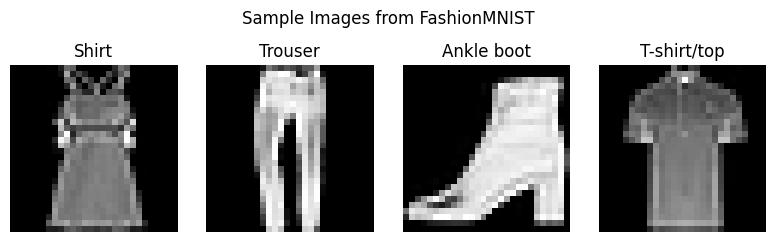

------------------------------

--- Step 4: Splitting FashionMNIST Training Data (90% Train / 10% Validation) ---
FashionMNIST sizes after split:
  Training Set:   54000
  Validation Set: 6000
  Test Set:       10000
------------------------------

--- Step 5: Creating DataLoaders for FashionMNIST ---
DataLoaders created.
------------------------------

--- Initializing Model, Loss, Optimizer for FashionMNIST ---
Model, Loss, Optimizer Initialized.
------------------------------

--- Step 6: Setting up TensorBoard for FashionMNIST ---
TensorBoard logs for FashionMNIST will be saved in: /Users/vinaygaddam/runs/FashionMNIST_LeNet5
------------------------------

--- Step 8 & 9: Training & Validating Model on FashionMNIST ---
Epoch [01/25], Train Loss: 0.5864, Train Acc: 78.33%, Val Loss: 0.4285, Val Acc: 84.93%, Time: 10.70s
Epoch [02/25], Train Loss: 0.3668, Train Acc: 86.53%, Val Loss: 0.3442, Val Acc: 87.55%, Time: 9.75s
Epoch [03/25], Train Loss: 0.3126, Train Acc: 88.37%, Val Loss: 

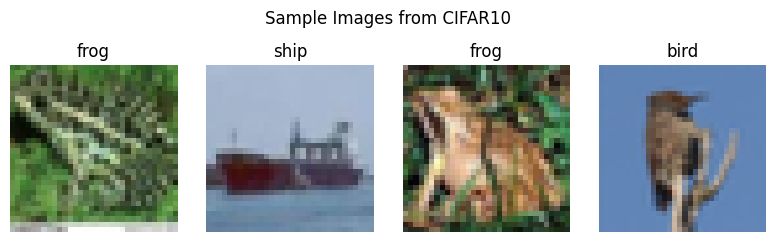

------------------------------

--- Step 4: Splitting CIFAR10 Training Data (90% Train / 10% Validation) ---
CIFAR10 sizes after split:
  Training Set:   45000
  Validation Set: 5000
  Test Set:       10000
------------------------------

--- Step 5: Creating DataLoaders for CIFAR10 ---
DataLoaders created.
------------------------------

--- Initializing Model, Loss, Optimizer for CIFAR10 ---
Model, Loss, Optimizer Initialized.
------------------------------

--- Step 6: Setting up TensorBoard for CIFAR10 ---
TensorBoard logs for CIFAR10 will be saved in: /Users/vinaygaddam/runs/CIFAR10_LeNet5
------------------------------

--- Step 8 & 9: Training & Validating Model on CIFAR10 ---
Epoch [01/25], Train Loss: 1.6164, Train Acc: 41.19%, Val Loss: 1.4120, Val Acc: 49.02%, Time: 38.36s
Epoch [02/25], Train Loss: 1.3034, Train Acc: 52.90%, Val Loss: 1.2661, Val Acc: 54.32%, Time: 36.91s
Epoch [03/25], Train Loss: 1.1680, Train Acc: 58.25%, Val Loss: 1.1775, Val Acc: 57.56%, Time: 37.14s
E

In [7]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.tensorboard import SummaryWriter
import os
import random

# --- Global Configuration ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 25 # Number of epochs to train for
BATCH_SIZE = 64
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1 # 10% for validation
SEED = 42 # for reproducibility

# Set seed for reproducibility
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
if DEVICE == 'cuda':
    torch.cuda.manual_seed(SEED)
    # Potentially add for full reproducibility on CUDA, might impact performance
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

print(f"Using device: {DEVICE}")

# --- Step 7: Implement CNN Models (LeNet-5) ---
# Modified to accept input channels (1 for MNIST/FashionMNIST, 3 for CIFAR10)
class LeNet5(nn.Module):
    """
    LeNet-5 architecture implementation using PyTorch.
    Adapted for 28x28 or 32x32 inputs and variable input channels.
    """
    def __init__(self, num_classes=10, in_channels=1): # Added in_channels argument
        super(LeNet5, self).__init__()
        self.in_channels = in_channels
        # Convolutional layers
        self.layer1 = nn.Sequential(
            # Use in_channels argument here
            nn.Conv2d(in_channels=self.in_channels, out_channels=6, kernel_size=5, stride=1, padding=2), # Padding=2 maintains dimensions for 28x28 and works for 32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: (N, 6, 14, 14) for 28x28; (N, 6, 16, 16) for 32x32 -> Let's recalculate FC size
        )
        # Recalculation for FC layer size based on 32x32 input (CIFAR-10):
        # Input: (N, 3, 32, 32)
        # Layer 1 Conv (pad=2): (N, 6, 32, 32) -> ((32-5+2*2)/1 + 1 = 32)
        # Layer 1 Pool: (N, 6, 16, 16)
        # Layer 2 Conv (pad=0): (N, 16, 12, 12) -> ((16-5+2*0)/1 + 1 = 12)
        # Layer 2 Pool: (N, 16, 6, 6)
        # Flattened size for CIFAR-10 = 16 * 6 * 6 = 576
        # Flattened size for FashionMNIST (28x28, pad=2) = 16 * 5 * 5 = 400 (as calculated before)
        # --> We need to calculate the flattened size dynamically or pass it. Let's calculate dynamically.

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dummy forward pass to determine the flattened size dynamically
        # This avoids hardcoding the size and makes the model more flexible
        with torch.no_grad():
            # Use a dummy input size appropriate for the datasets (e.g., 32x32 for CIFAR, 28x28 for MNIST)
            # Since CIFAR is larger, using its size works for calculation.
            # If using datasets with different sizes, might need separate models or more complex logic.
            dummy_input_size = 32 if self.in_channels == 3 else 28 # Assume 3 channels means 32x32
            dummy_input = torch.zeros(1, self.in_channels, dummy_input_size, dummy_input_size)
            dummy_output = self.layer2(self.layer1(dummy_input))
            self._flattened_size = int(torch.flatten(dummy_output, 1).shape[1])
            # print(f"Calculated flattened size: {self._flattened_size}") # Debug print

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=self._flattened_size, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=num_classes) # Output layer
        )

    def forward(self, x):
        """Forward pass through the network."""
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1) # Flatten the tensor for the FC layers
        x = self.fc_layers(x)
        return x

# --- Helper Function for Visualization (Step 2) ---
def visualize_samples(dataset_raw, class_names, dataset_name, num_samples=4):
    """Visualizes a few random samples from the raw dataset."""
    print(f"\n--- Step 2: Exploring and Visualizing Data ({dataset_name}) ---")

    # Function to show an image (expects a PIL Image)
    def imshow_pil(img, title=None):
        # Convert PIL image to numpy array. Handles both grayscale and RGB.
        img_array = np.asarray(img)
        if img_array.ndim == 2: # Grayscale
             plt.imshow(img_array, cmap='gray')
        else: # RGB
             plt.imshow(img_array)
        plt.axis('off') # Hide axes
        if title:
            plt.title(title)

    # Get a few random samples directly from the raw dataset
    random_indices = random.sample(range(len(dataset_raw)), num_samples)

    # Show images
    print(f"Visualizing {num_samples} random raw training examples from {dataset_name}:")
    fig = plt.figure(figsize=(8, 2.5)) # Adjusted figure size slightly
    for i, idx in enumerate(random_indices):
        image_raw, label_raw = dataset_raw[idx] # Access dataset directly
        ax = fig.add_subplot(1, num_samples, i+1, xticks=[], yticks=[])
        imshow_pil(image_raw, title=class_names[label_raw])
    plt.suptitle(f"Sample Images from {dataset_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
    print("-" * 30)

# --- Main Experiment Function ---
def run_experiment(dataset_name, device, num_epochs, batch_size, learning_rate, validation_split, seed):
    """Loads a dataset, trains LeNet-5, evaluates, and logs results."""

    print("\n" + "="*50)
    print(f" STARTING EXPERIMENT FOR: {dataset_name} ")
    print("="*50)

    # --- Dataset Specific Configuration ---
    in_channels = 1 # Default for grayscale
    if dataset_name == 'FashionMNIST':
        dataset_class = datasets.FashionMNIST
        normalize_mean = (0.2860,)
        normalize_std = (0.3530,)
        class_names = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
        in_channels = 1
    elif dataset_name == 'CIFAR10':
        dataset_class = datasets.CIFAR10
        # Standard mean/std for CIFAR10
        normalize_mean = (0.4914, 0.4822, 0.4465)
        normalize_std = (0.2023, 0.1994, 0.2010)
        class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck')
        in_channels = 3 # CIFAR10 has 3 color channels
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    # --- Step 1 & 3: Load Dataset and Define Preprocessing ---
    print(f"\n--- Step 1 & 3: Loading {dataset_name} and Defining Preprocessing ---")
    transform = transforms.Compose([
        transforms.ToTensor(), # Step 5: Convert Data to Torch Format
        transforms.Normalize(normalize_mean, normalize_std)
    ])
    try:
        full_train_dataset_raw = dataset_class(root='./data', train=True, download=True)
        full_train_dataset_transformed = dataset_class(root='./data', train=True, download=False, transform=transform)
        test_dataset = dataset_class(root='./data', train=False, download=True, transform=transform)
    except Exception as e:
        print(f"Error downloading or loading {dataset_name}: {e}")
        print("Please check your internet connection, SSL certificates, or disk space.")
        return # Stop experiment for this dataset if loading fails

    # --- Step 2: Explore and Visualize Data ---
    visualize_samples(full_train_dataset_raw, class_names, dataset_name)

    # --- Step 4: Split Training Data ---
    print(f"\n--- Step 4: Splitting {dataset_name} Training Data ({(1-validation_split)*100:.0f}% Train / {validation_split*100:.0f}% Validation) ---")
    num_train_total = len(full_train_dataset_transformed)
    num_val = int(validation_split * num_train_total)
    num_train = num_train_total - num_val
    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset = random_split(full_train_dataset_transformed, [num_train, num_val], generator=generator)
    print(f"{dataset_name} sizes after split:")
    print(f"  Training Set:   {len(train_dataset)}")
    print(f"  Validation Set: {len(val_dataset)}")
    print(f"  Test Set:       {len(test_dataset)}")
    print("-" * 30)

    # --- Step 5: Create DataLoaders ---
    print(f"\n--- Step 5: Creating DataLoaders for {dataset_name} ---")
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    print("DataLoaders created.")
    print("-" * 30)

    # --- Initialize Model, Loss, Optimizer ---
    print(f"\n--- Initializing Model, Loss, Optimizer for {dataset_name} ---")
    # Pass the correct number of input channels to the model
    model = LeNet5(num_classes=len(class_names), in_channels=in_channels).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print("Model, Loss, Optimizer Initialized.")
    # print(model) # Optional: print model summary
    print("-" * 30)

    # --- Step 6: Setup TensorBoard ---
    print(f"\n--- Step 6: Setting up TensorBoard for {dataset_name} ---")
    log_dir = os.path.join('runs', f"{dataset_name}_LeNet5")
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=log_dir)
    print(f"TensorBoard logs for {dataset_name} will be saved in: {os.path.abspath(log_dir)}")
    print("-" * 30)

    # --- Step 8 & 9: Train Model & Evaluate Train/Validation Accuracy ---
    print(f"\n--- Step 8 & 9: Training & Validating Model on {dataset_name} ---")
    start_time = time.time()
    best_val_acc = 0.0
    final_train_acc_at_best_val = 0.0
    final_val_acc_at_best_val = 0.0
    final_train_loss_at_best_val = float('inf')
    final_val_loss_at_best_val = float('inf')


    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        epoch_train_loss = running_loss / len(train_dataset)
        epoch_train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = 100 * correct_val / total_val

        epoch_end_time = time.time()
        print(f"Epoch [{epoch+1:02d}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, "
              f"Time: {epoch_end_time - epoch_start_time:.2f}s")

        # Log to TensorBoard
        writer.add_scalar('Loss/Train', epoch_train_loss, epoch + 1)
        writer.add_scalar('Accuracy/Train', epoch_train_acc, epoch + 1)
        writer.add_scalar('Loss/Validation', epoch_val_loss, epoch + 1)
        writer.add_scalar('Accuracy/Validation', epoch_val_acc, epoch + 1)
        writer.flush()

        # Store results from the epoch with the best validation accuracy
        if epoch_val_acc > best_val_acc:
             best_val_acc = epoch_val_acc
             final_train_acc_at_best_val = epoch_train_acc
             final_val_acc_at_best_val = epoch_val_acc
             final_train_loss_at_best_val = epoch_train_loss
             final_val_loss_at_best_val = epoch_val_loss

    training_time = time.time() - start_time
    print(f"--- {dataset_name} Training Finished --- Total Time: {training_time:.2f}s ({training_time/60:.2f} minutes)")
    print("-" * 30)

    # --- Step 10: Evaluate on Test Set ---
    print(f"\n--- Step 10: Evaluating on {dataset_name} Test Set ---")
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    final_test_loss = test_loss / len(test_dataset)
    final_test_acc = 100 * correct_test / total_test
    print(f"{dataset_name} Test Loss: {final_test_loss:.4f}")
    print(f"{dataset_name} Test Accuracy: {final_test_acc:.2f}%")
    print("-" * 30)

    # --- Final Summary for Grading ---
    print("\n" + "="*30)
    print(f"   RESULTS SUMMARY FOR: {dataset_name}")
    print("="*30)
    print(f"CNN Architecture:   LeNet-5")
    print(f"Epochs Trained:     {num_epochs}")
    print(f"Batch Size:         {batch_size}")
    print(f"Learning Rate:      {learning_rate}")
    print(f"Optimizer:          Adam")
    print(f"Validation Split:   {validation_split*100:.0f}%")
    print("-" * 30)
    print("Metrics at Epoch with Best Validation Accuracy:")
    # Handle case where training might not improve (best_val_acc remains 0)
    if best_val_acc > 0:
        print(f"  Training Accuracy:   {final_train_acc_at_best_val:.2f}%")
        print(f"  Validation Accuracy: {final_val_acc_at_best_val:.2f}%")
        print(f"  Training Loss:       {final_train_loss_at_best_val:.4f}")
        print(f"  Validation Loss:     {final_val_loss_at_best_val:.4f}")
    else:
        print("  No improvement in validation accuracy observed.")
    print("-" * 30)
    print(f"Final Test Accuracy:   {final_test_acc:.2f}%")
    print(f"Final Test Loss:       {final_test_loss:.4f}")
    print("="*30)

    # Close the TensorBoard writer
    writer.close()
    print(f"\nTensorBoard writer for {dataset_name} closed.")
    print("="*50)
    print(f" COMPLETED EXPERIMENT FOR: {dataset_name} ")
    print("="*50 + "\n")


# --- Main Execution Block ---
if __name__ == "__main__":
    # List of datasets to run experiments on
    datasets_to_run = ['FashionMNIST', 'CIFAR10']

    for dataset in datasets_to_run:
        run_experiment(
            dataset_name=dataset,
            device=DEVICE,
            num_epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            validation_split=VALIDATION_SPLIT,
            seed=SEED
        )

    print("\nAll experiments completed.")
    print("Check the 'runs' directory for TensorBoard logs:")
    for dataset in datasets_to_run:
         print(f" - runs/{dataset}_LeNet5")
    print("\nTo view TensorBoard, run the following command in your terminal:")
    print(f"tensorboard --logdir \"{os.path.abspath('runs')}\"")

